## Aleatoric Uncertainty

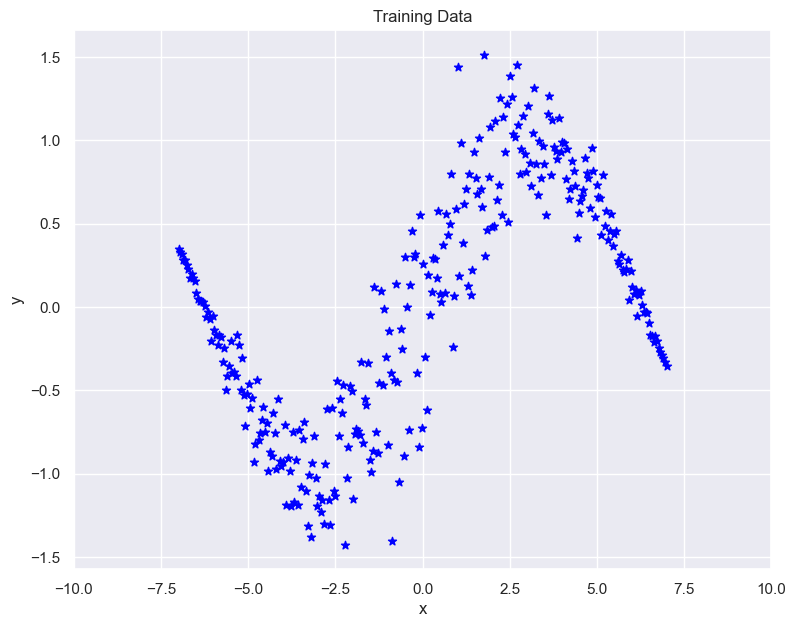

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns


sns.set(rc={'figure.figsize': (9, 7)})

def sample_dataset(start, end, n):
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]
    sample_var = [((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs()
    return x, y

start = -7
end = 7
n = 300

x_train, y_train = sample_dataset(start, end, n)
# scatter(x_train, y_train, c="blue", marker="*")

plt.scatter(x_train, y_train, c="blue", marker="*")
plt.xlim([-10, 10])
plt.title("Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Distribution for test dataset 

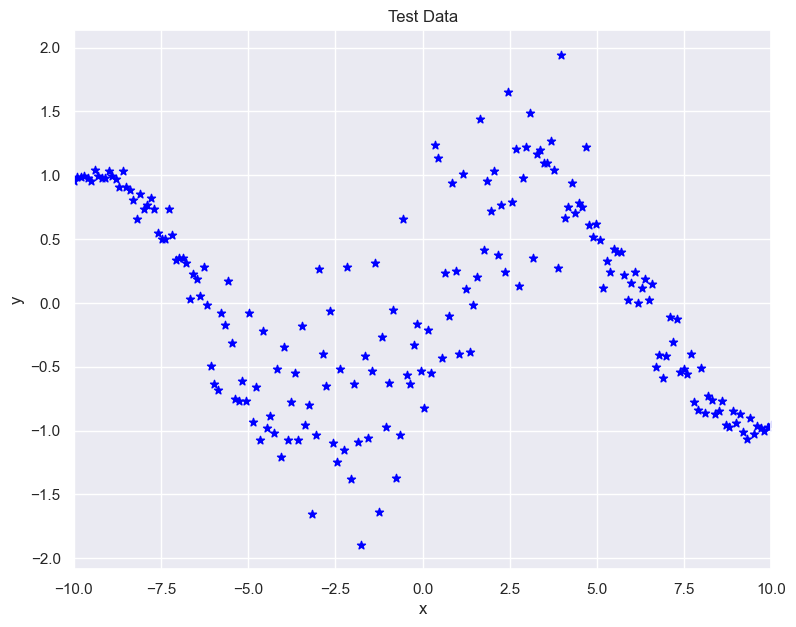

In [2]:
x_test, y_test = sample_dataset(-10, 10, 200)
# scatter(x_test, y_test, c="green", marker="*")

plt.scatter(x_test, y_test, c="blue", marker="*")
plt.xlim([-10, 10])
plt.title("Test Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [3]:
import tensorflow as tf
# Convert data to tensors
tensor_x_train = tf.convert_to_tensor(x_train.reshape(-1, 1), dtype=tf.float32)
tensor_y_train = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)
tensor_x_test = tf.convert_to_tensor(x_test.reshape(-1, 1), dtype=tf.float32)

## Training and testing Aleatoric modell

2024-11-19 04:28:23.206 | INFO     | uqX.config:<module>:11 - PROJ_ROOT path is: C:\Users\Studium\Documents\uni\bachelorarbeit\uqX


()


C:\Users\Studium\Documents\uni\bachelorarbeit\uqX\.venv\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'uq_x_aleatoric_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 0, Loss: 0.604046642780304
Epoch 200, Loss: -1.0593311786651611
Epoch 400, Loss: -1.146592140197754
Epoch 600, Loss: -1.1273634433746338
Epoch 800, Loss: -1.1442214250564575


C:\Users\Studium\Documents\uni\bachelorarbeit\uqX\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Studium\Documents\uni\bachelorarbeit\uqX\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Studium\Documents\uni\bachelorarbeit\uqX\.venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Studium\Documents\uni\bachelorarbeit\uqX\.venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

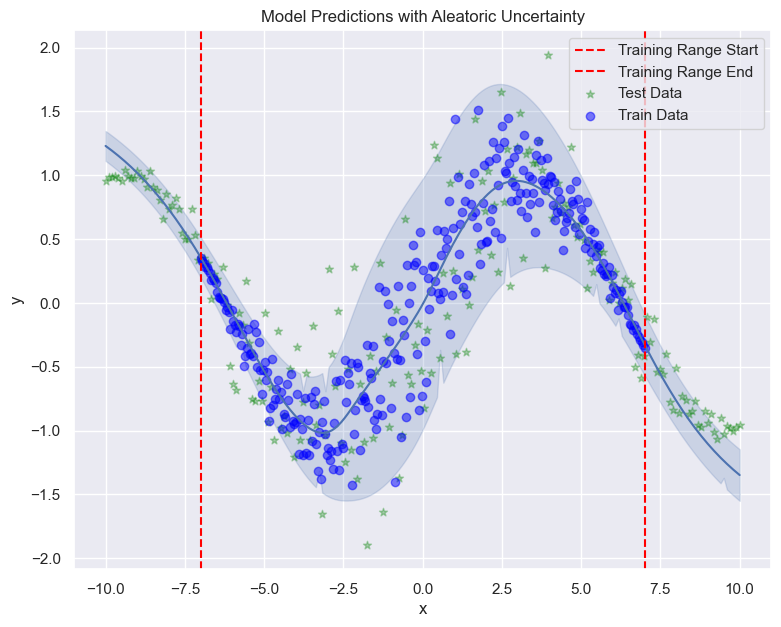

In [4]:
from uqX.modeling.uqXAleatoricModelling import uqXAleatoricModel

# Instantiate the model
net = ()

print(net)
# print("Params:", net.count_params())
      
# Instantiate and train the model
model = uqXAleatoricModel()
model.train_model(tensor_x_train, tensor_y_train, epochs=1000, learning_rate=0.01)

# Plot the results using the method in the class
model.make_aleatoric_plot(tensor_x_test, y_test, start, end)



## making sure of dependency compatilibility (tf - tf.prob - tf.keras)

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp

print("TensorFlow version:", tf.__version__)  # Should print 2.17.0
print("TFP version:", tfp.__version__)        # Should print 0.24.0

# Test TF-Keras integration
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

print("Model initialized successfully.")




TensorFlow version: 2.17.0
TFP version: 0.24.0
Model initialized successfully.


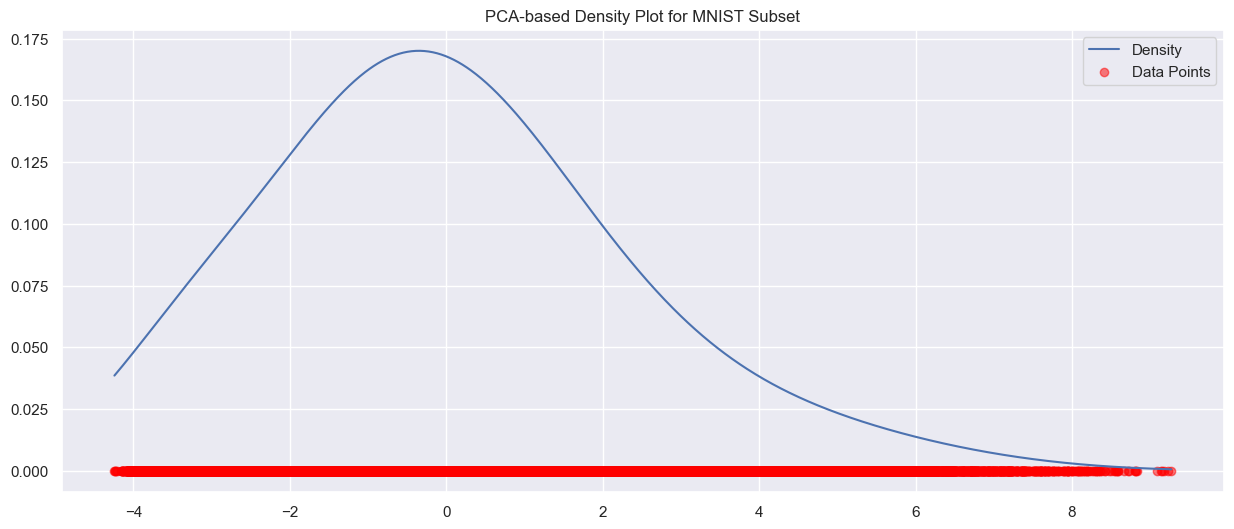

In [6]:
import tensorflow as tf
from uqX.modeling.uqXEpistemicModelling import uqXEpisticModel

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784) / 255.0
X_val = X_val.reshape(-1, 784) / 255.0

uq_model = uqXEpisticModel()
uq_model.plot_density_with_pca(X_train)

## testing out the BNN

In [7]:
import tensorflow as tf
from uqX.modeling.uqXEpistemicModelling import uqXEpisticModel

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784) / 255.0
X_val = X_val.reshape(-1, 784) / 255.0
data = (X_train, y_train, X_val, y_val)

uq_model = uqXEpisticModel()
uq_model.train_model(data, uq_method="bayes_by_backprop")

AttributeError: 'tuple' object has no attribute 'rank'

## testing out the MC Dropout

In [ ]:
import tensorflow as tf
from uqX.modeling.uqXEpistemicModelling import uqXEpisticModel

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784) / 255.0
X_val = X_val.reshape(-1, 784) / 255.0

data = (X_train, y_train, X_val, y_val)

# Train the model with MC Dropout
uq_model = uqXEpisticModel()
uq_model.train_model(data, uq_method="mc_dropout")

# # Make predictions with uncertainty
# mean_pred, uncertainty = uq_model.predict_with_mc_dropout(X_val[:100])
# 
# # Print predictions and uncertainty for the first sample
# print("Mean Prediction:", mean_pred[0])
# print("Uncertainty:", uncertainty[0])